In [29]:
pip install langchain_community langchain langgraph cassio

Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.3 MB 2.2 MB/s eta 0:00:02
   --- ------------------------------------ 0.2/2.3 MB 2.2 MB/s eta 0:00:01
   ----- ---------------------------------- 0.3/2.3 MB 2.3 MB/s eta 0:00:01
   ------ --------------------------------- 0.4/2.3 MB 2.3 MB/s eta 0:00:01
   -------- ------------------------------- 0.5/2.3 MB 2.3 MB/s eta 0:00:01
   -------- ------------------------------- 0.5/2.3 MB 2.3 MB/s eta 0:00:01
   ---------- ----------------------------- 0.6/2.3 MB 1.9 MB/s eta 0:00:01
   ----------- ---------------------------- 0.7/2.3 MB 1.9 MB/s eta 0:00:01
   ------------- -------------------------- 0.8/2.3 MB 2.0 MB/s eta 0:00:01
   --------------- ------------------------ 0.9/2.3 MB 2.0 MB/s eta 0:00:01
   ---------------- ----------------------- 1.0/2.3 MB 1.9 MB/s eta 0:00:01
   ------------------ --------------------- 1.1/2.3 MB 2.0 MB/s eta 0:00:01
   ----------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.121 requires chromadb<0.5.0,>=0.4.24, but you have chromadb 0.5.5 which is incompatible.


In [31]:
#### Index

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

In [32]:
# Add to vectorDB
astra_vector_store=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
)

In [33]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 194 headlines.


In [34]:
retriever=astra_vector_store.as_retriever()

In [35]:
retriever.invoke("What is Prompt Engineering",ConsistencyLevel="LOCAL_ONE")

[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experiment

In [82]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )




# LLM with function call
from langchain_groq import ChatGroq
import os

groq_api_key = "XXXX"
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "who is Kamal R Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))    

datasource='wiki_search'
datasource='vectorstore'


In [73]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [74]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [75]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [77]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [78]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [79]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

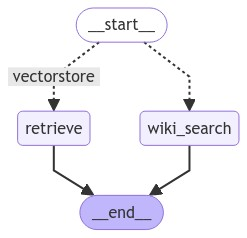

In [80]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [96]:
from pprint import pprint

# Inputs
inputs = {
    "question": "What is Prompt Engineering?"
}

# Run the application and process the stream of outputs
for output in app.stream(inputs):
    for key, value in output.items():
        # Print the node name
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
# Handling both single and multiple Document objects
documents = value['documents']

# Debugging: Print the structure of the document
if isinstance(documents, list):
    for doc in documents:
        pprint(doc.dict())  # Print the entire document structure to understand its content
else:
    pprint(documents.dict())  # Print the structure of a single document

# Accessing metadata and description if the key exists
if isinstance(documents, list):
    for doc in documents:
        doc_dict = doc.dict()
        if 'metadata' in doc_dict and 'description' in doc_dict['metadata']:
            description = doc_dict['metadata']['description']
            pprint(description)
        else:
            pprint("Metadata or description key not found.")
else:
    doc_dict = documents.dict()
    if 'metadata' in doc_dict and 'description' in doc_dict['metadata']:
        description = doc_dict['metadata']['description']
        pprint(description)
    else:
        pprint("Metadata or description key not found.")


---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
{'id': None,
 'metadata': {'description': 'Prompt Engineering, also known as In-Context '
                             'Prompting, refers to methods for how to '
                             'communicate with LLM to steer its behavior for '
                             'desired outcomes without updating the model '
                             'weights. It is an empirical science and the '
                             'effect of prompt engineering methods can vary a '
                             'lot among models, thus requiring heavy '
                             'experimentation and heuristics.\n'
                             'This post only focuses on prompt engineering for '
                             'autoregressive language models, so nothing with '
                             'Cloze tests, image generation or multimodality '
                             'models.',
              'lan

In [97]:
from pprint import pprint

# Inputs
inputs = {
    "question": "BMW?"
}

# Run the application and process the stream of outputs
for output in app.stream(inputs):
    for key, value in output.items():
        # Print the node name
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
# Handling both single and multiple Document objects
documents = value['documents']

# Debugging: Print the structure of the document
if isinstance(documents, list):
    for doc in documents:
        pprint(doc.dict())  # Print the entire document structure to understand its content
else:
    pprint(documents.dict())  # Print the structure of a single document

# Accessing metadata and description if the key exists
if isinstance(documents, list):
    for doc in documents:
        doc_dict = doc.dict()
        if 'metadata' in doc_dict and 'description' in doc_dict['metadata']:
            description = doc_dict['metadata']['description']
            pprint(description)
        else:
            pprint("Metadata or description key not found.")
else:
    doc_dict = documents.dict()
    if 'metadata' in doc_dict and 'description' in doc_dict['metadata']:
        description = doc_dict['metadata']['description']
        pprint(description)
    else:
        pprint("Metadata or description key not found.")

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
BMW?
"Node 'wiki_search':"
'\n---\n'
{'id': None,
 'metadata': {},
 'page_content': 'Page: BMW\n'
                 'Summary: Bayerische Motoren Werke AG, commonly abbreviated '
                 'to BMW (German pronunciation: [ˌbeːʔɛmˈveː] ), is a German '
                 'multinational manufacturer of luxury vehicles and '
                 'motorcycles headquartered in Munich, Bavaria, Germany. The '
                 'company was founded in 1916 as a manufacturer of aircraft '
                 'engines, which it produced from 1917 to 1918 and again from '
                 '1933 to 1945 creating engines for aircraft that were used in '
                 'the Second World War.   \n'
                 'Automobiles are marketed under the brands BMW, Mini and Rol',
 'type': 'Document'}
'Metadata or description key not found.'
